In [82]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime


In [83]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)
    
with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

# convert friends to list
df_users['friends'] = df_users['friends'].apply(lambda x: x.split(','))
# convert elite to list
df_users['elite'] = df_users['elite'].apply(lambda x: x.split(','))

C:\Users\maysa\AppData\Local\Temp\ipykernel_15380\4277523074.py:5: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\maysa\AppData\Local\Temp\ipykernel_15380\4277523074.py:12: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\maysa\AppData\Local\Temp\ipykernel_15380\4277523074.py:18: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [84]:
user_ids_set = set(df_users['user_id'])

def remove_non_existing_friends(friends):
    return list(set(friends) & user_ids_set)

print("Before removing non-existing friends:", df_users['friends'].apply(len).sum())

df_users['friends'] = df_users['friends'].apply(remove_non_existing_friends)

print("After removing non-existing friends:", df_users['friends'].apply(len).sum())
print("------------------------------------")
print("Before removing users with no friends:", len(df_users))

df_users = df_users[df_users['friends'].apply(len) > 0]

print("After removing users with no friends:", len(df_users))


Before removing non-existing friends: 18945313
After removing non-existing friends: 14555
------------------------------------
Before removing users with no friends: 245354
After removing users with no friends: 14555


In [85]:
print("Before removing reviews with non-existant users: ", len(df_reviews))

# remove review if user is not in the graph
df_reviews = df_reviews[df_reviews['user_id'].isin(df_users['user_id'])]

print("After removing: ", len(df_reviews))

print("------------------------------------")

print("Before removing users with less than 2 reviews: ", len(df_users))

# remove user if they have less than 2 reviews
df_users = df_users[df_users['review_count'] >= 2]

print("After removing: ", len(df_users))

print("------------------------------------")

print("Before removing reviews of non-existant businesses: ", len(df_reviews))

# remove review if business is not in the graph
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

print("After removing: ", len(df_reviews))

Before removing reviews with non-existant users:  635364
After removing:  90306
------------------------------------
Before removing users with less than 2 reviews:  14555
After removing:  13769
------------------------------------
Before removing reviews of non-existant businesses:  90306
After removing:  90305


In [86]:
print("Before removing businesses with no reviews: ", len(df_businesses))

# remove business if they have less than 2 reviews
df_businesses = df_businesses[df_businesses['review_count'] >= 1]

print("After removing: ", len(df_businesses))

print("------------------------------------")

print("Before bussinesses that are not opened: ", len(df_businesses))

# remove businesses that are not opened
df_businesses = df_businesses[df_businesses['is_open'] == 1]

print("After removing: ", len(df_businesses))

Before removing businesses with no reviews:  6209
After removing:  6209
------------------------------------
Before bussinesses that are not opened:  6209
After removing:  4649


In [87]:
# remove reviews if they are not in the business dataset
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

# reset indexes
df_businesses.reset_index(drop=True, inplace=True)
df_users.reset_index(drop=True, inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

In [88]:
import plotly.graph_objects as go

lats = df_businesses['latitude']
lons = df_businesses['longitude']
names = df_businesses['name']
stars = df_businesses['stars']

colors = []
for star in stars:
    if star >= 4.0:
        colors.append('green')
    elif star >= 3.0:
        colors.append('yellow')
    else:
        colors.append('red')
        

fig = go.Figure(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=3,
            color=colors,
            opacity=0.7
        ),
        text=names,
    ))
legend_entries = [
    {'label': 'Rating >= 4.5', 'color': 'green'},
    {'label': '4.0 <= Rating < 4.5', 'color': 'yellow'},
    {'label': 'Rating < 4.0', 'color': 'red'}
]

for entry in legend_entries:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=0),
        showlegend=True,
        name=entry['label'],
        line=dict(color=entry['color'])
    ))

fig.update_layout(
    title= "Business Locations in New Orleans",
    autosize = True,
    hovermode='closest',
    mapbox =dict(
        accesstoken="pk.eyJ1IjoidG9tYXNnNyIsImEiOiJjbHVuNWtsOWEwZnNlMmpwbmtqM2gwa213In0.8cGFuz6zBfMNItCu791cYQ",
        bearing=0,
        center=dict(
            lat=30.0,
            lon=-90.0
        ),
        pitch=0,
        zoom=10
    ),
)

fig.show()
    

In [89]:
# top 5 categories
df_businesses['categories'] = df_businesses['categories'].fillna('')
categories = df_businesses['categories'].apply(lambda x: x.split(','))
categories = categories.explode()
categories = categories.value_counts()
categories = categories[:5]

fig = go.Figure(go.Bar(
    x=categories.index,
    y=categories.values
))

fig.update_layout(
    title="Top 5 Categories",
    xaxis_title="Category",
    yaxis_title="Count"
)

fig.show()

In [90]:
ratings = df_reviews['stars'].value_counts()

# Calcular a porcentagem de cada classificação
total_ratings = ratings.sum()
percentage_ratings = (ratings / total_ratings) * 100

# Criar texto para exibir a porcentagem em cada barra
text = [f'{count} ({percentage:.2f}%)' for count, percentage in zip(ratings.values, percentage_ratings.values)]

fig = go.Figure(go.Bar(
    x=ratings.index,
    y=ratings.values,
    text=text,  
    textposition='auto',
))

fig.update_layout(
    title="Distribution of User Ratings",
    xaxis_title="Rating",
    yaxis_title="Count"
)

fig.show()


13769


Number of nodes:  13769


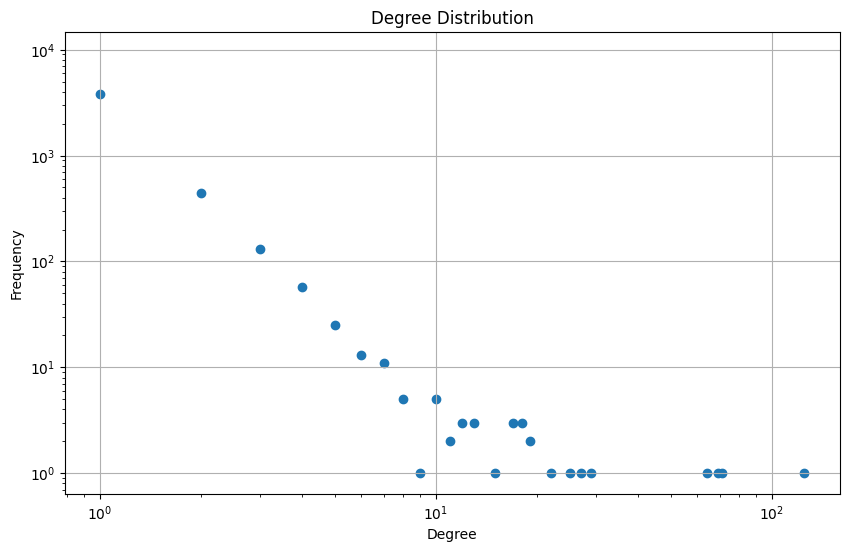

Nodes and edges: 13769 3179


In [91]:
network = nx.Graph()

print(len(df_users['user_id']))

network.add_nodes_from(df_users['user_id'])



for user,friends in zip(df_users['user_id'], df_users['friends']):
    for friend in friends:
        if friend in df_users['user_id'].values:
            network.add_edge(user, friend)

print("Number of nodes: ", network.number_of_nodes())
# sorted list with degree of each node
degree_sequence = sorted([d for n, d in network.degree()], reverse=True)

degree_freq = {}
for degree in degree_sequence:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1


# create degree distribution plot, not histogram
plt.figure(figsize=(10, 6))
plt.scatter(degree_freq.keys(), degree_freq.values())
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.grid(True)
plt.title('Degree Distribution')
plt.show()

print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

In [92]:
# len of list where degree is better than 10
topX = len([d for n, d in network.degree() if d > 10])
print(topX)

# remove isolated
network.remove_nodes_from(list(nx.isolates(network)))

25


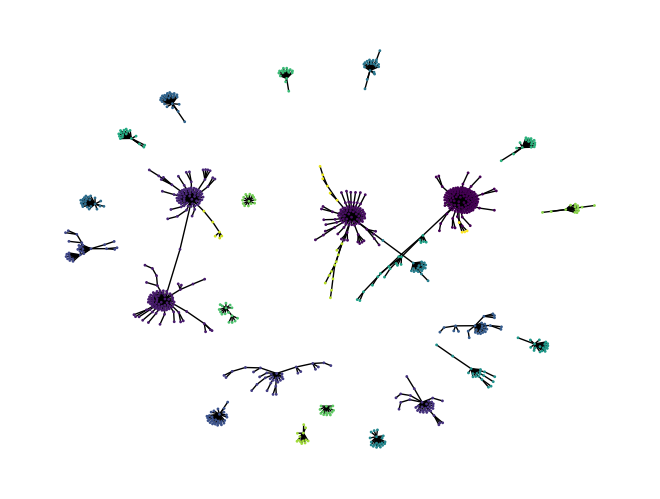

In [93]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network, node))

g_sub = network.subgraph(subgraph_nodes)

# Communities 
communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()


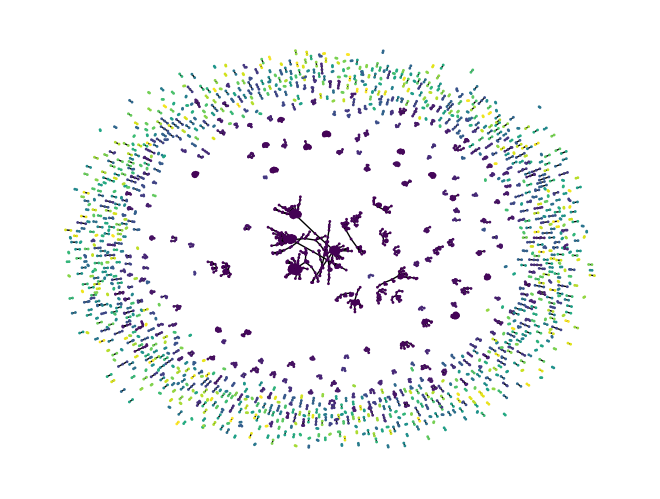

In [94]:
# find communities in main graph
communities = nx.community.greedy_modularity_communities(network)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in network.nodes()]

pos = nx.spring_layout(network)
nx.draw(network, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

In [95]:
# print number of nodes, edges 
print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

Nodes and edges: 4500 3179


In [96]:
betwenness = nx.betweenness_centrality(network)

sorted_betweenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

elite_users = list(df_users[df_users['elite'].apply(len) > 0]['user_id'])

top_percent = 10
top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by betweenness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by betweenness centrality: 100.0%


In [97]:
degree = nx.degree_centrality(network)

sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_degree[:int(len(sorted_degree) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by degree centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by degree centrality: 100.0%


In [98]:
page_rank = nx.pagerank(network)

sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_page_rank[:int(len(sorted_page_rank) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by page rank: {percentage_elite}%")

Percentage of elite users in top 10% of users by page rank: 100.0%


In [99]:
# total num of reviews for elite and non-elite users
elite_users_reviews = df_reviews[df_reviews['user_id'].isin(elite_users)]
non_elite_users_reviews = df_reviews[~df_reviews['user_id'].isin(elite_users)]

elite_users_reviews_count = len(elite_users_reviews)
non_elite_users_reviews_count = len(non_elite_users_reviews)

print(f"Total number of reviews by elite users: {elite_users_reviews_count}")
print(f"Total number of reviews by non-elite users: {non_elite_users_reviews_count}")

Total number of reviews by elite users: 71944
Total number of reviews by non-elite users: 622


In [100]:
user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

user_reviews = {}

for user,group in user_grouped_reviews.groupby('user_id'):
    user_reviews[user] = group.set_index('business_id')['stars'].to_dict()
    
# print user reviews index 0 
print(user_reviews[list(user_reviews.keys())[0]])

{'biz_GBTPC53ZrG1ZBY3DT8Mbcw': 4.0, 'biz_LY6hHivaMJIPJNv_3oBIPQ': 1.0, 'biz_hLlDzRaDGN-0SlEWk0xTpQ': 5.0, 'biz_mnq8JNUjIBwUoLBk-b2V9g': 4.0}


In [101]:
network_copy = network.copy()

def calc_similarity(common_businesses,reviews1, reviews2):

    stars1 = np.array([reviews1[b] for b in common_businesses])
    stars2 = np.array([reviews2[b] for b in common_businesses])
    
    return np.corrcoef(stars1, stars2)[0, 1]  

edges = []
for user1, user2 in combinations(network.nodes(), 2):
    reviews1 = user_reviews.get(user1, {})
    reviews2 = user_reviews.get(user2, {})
    
    common_businesses = set(reviews1.keys()) & set(reviews2.keys())
    
    common_reviews_count = len(common_businesses)
    
    if common_reviews_count >= 5:
        similarity = calc_similarity(common_businesses, reviews1, reviews2)
        
        if similarity > 0.5:
            edges.append((user1, user2, similarity))

print(edges[0:5])


c:\Users\maysa\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\maysa\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



[('j14WgRoU_-2ZE1aw1dXrJg', '0Igx-a1wAstiBDerGxXk2A', 0.6560203813202515), ('SZDeASXq7o05mMNLshsdIA', 'iZpzJ9k4dDgBjuC27MbjvQ', 0.6454972243679028), ('SZDeASXq7o05mMNLshsdIA', 'GJv1yf_IhUZqpDjFr86DmA', 0.7637626158259733), ('QWxW_pApmpY9iPApC8P-UQ', 'pgQurApfbrV-rPKZKYo-Tw', 0.5270462766947299), ('QWxW_pApmpY9iPApC8P-UQ', 'Q5TBKfv2ThhfGFv97gWv3g', 0.5345224838248487)]


In [102]:
for edge in edges:
    network_copy.add_edge(edge[0], edge[1])
    

print("Nodes and edges:", network_copy.number_of_nodes(), network_copy.number_of_edges())

Nodes and edges: 4500 6829


In [103]:
# len of list where degree is better than 10
topX = len([d for n, d in network_copy.degree() if d > 10])
print(topX)

# remove isolated
network_copy.remove_nodes_from(list(nx.isolates(network_copy)))

237


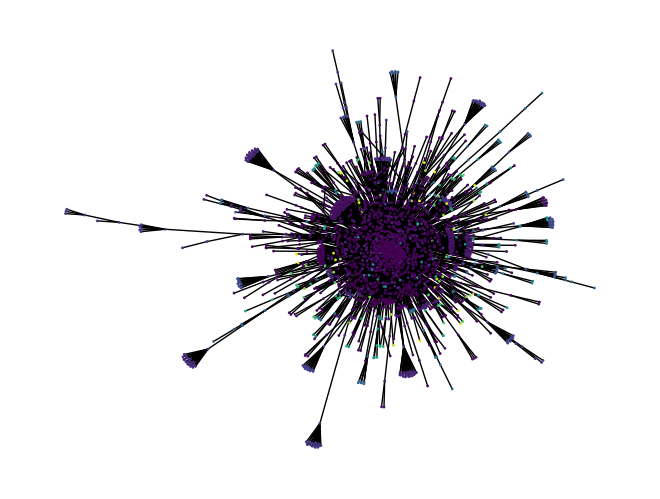

In [104]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network_copy.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network_copy, node))

g_sub = network_copy.subgraph(subgraph_nodes)

# Communities 
sub_communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(sub_communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

In [121]:
# print degrees sorted
print(sorted(dict(network_copy.degree()).items(), key=lambda x: x[1], reverse=True)[:10])

[('5tXRxr4T24Awl7vjyCvIcQ', 194), ('Xw7ZjaGfr0WNVt6s_5KZfA', 166), ('0Igx-a1wAstiBDerGxXk2A', 135), ('E4BsVQnG5zetbwv2x8QIWg', 114), ('GJv1yf_IhUZqpDjFr86DmA', 108), ('h8_Mzh_ndxFwxQgLZsRs9w', 108), ('iZpzJ9k4dDgBjuC27MbjvQ', 96), ('riWDgbauId8TK7YFVgMNJw', 90), ('CfX4sTIFFNaRchNswqhVfg', 90), ('DAeC-Y66n-jNMJJw4oAfNQ', 83)]


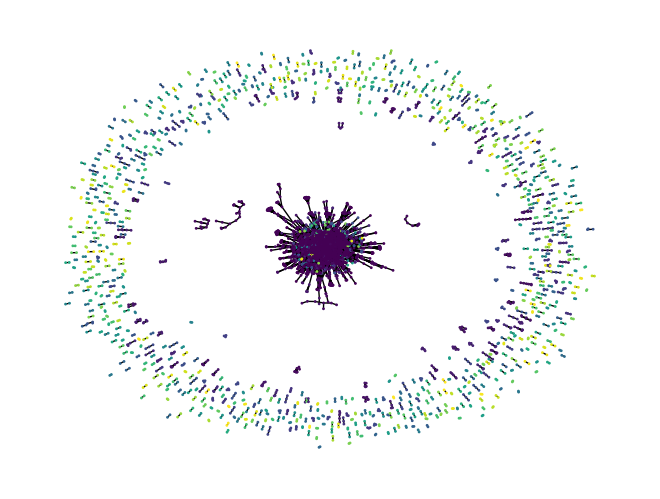

In [105]:
# Communities 
communities_2 = nx.community.greedy_modularity_communities(network_copy)

node_to_community_2 = {}
for i, community in enumerate(communities_2):
    for node in community:
        node_to_community_2[node] = i

# Color nodes by community
colors = [node_to_community_2[node] for node in network_copy.nodes()]

pos = nx.spring_layout(network_copy)
nx.draw(network_copy, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()
    

# Recomender systems

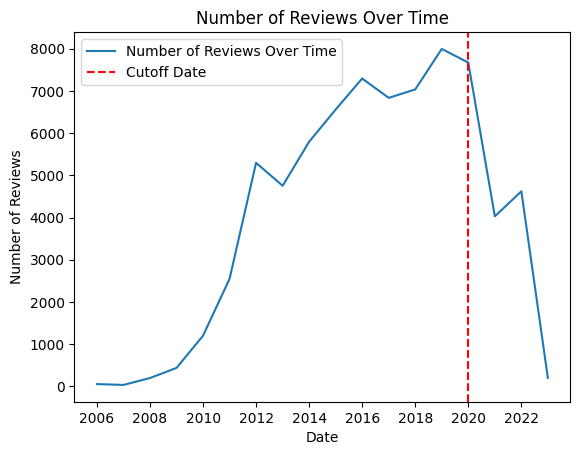

In [106]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_reviews[['user_id', 'business_id', 'stars']], reader)

# build trainset in a way that 80% are reviews from the past and 20% are the most recent reviews
df_reviews_sorted = df_reviews.sort_values(by='date')

total_reviews = len(df_reviews_sorted)

cutoff_index = int(total_reviews * 0.8)

cutoff_data = df_reviews_sorted.iloc[cutoff_index]['date']

train_data = df_reviews_sorted[df_reviews_sorted['date'] < cutoff_data]
test_data = df_reviews_sorted[df_reviews_sorted['date'] >= cutoff_data]

reviews_over_year = df_reviews_sorted.resample('YE', on='date').size()
cutoff_index = int(len(reviews_over_year) * 0.8)

cutoff_date = reviews_over_year.index[cutoff_index]

plt.figure
plt.plot(reviews_over_year.index, reviews_over_year.values, label='Number of Reviews Over Time')
plt.axvline(cutoff_date, color='red', linestyle='--', label='Cutoff Date')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

In [107]:
trainset = Dataset.load_from_df(train_data[['user_id', 'business_id', 'stars']], reader).build_full_trainset() # past reviews
testset = list(test_data[['user_id', 'business_id', 'stars']].itertuples(index=False, name=None)) # most recent reviews

In [108]:
from surprise import SVD, Dataset, Reader,NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from time import time

def evaluate_algorithm(algo, trainset, testset):
    start_train_time = time()
    algo.fit(trainset)
    end_train_time = time()
    train_time = end_train_time - start_train_time
    
    start_test_time = time()
    predictions = algo.test(testset)
    end_test_time = time()
    test_time = end_test_time - start_test_time
    
    rmse = accuracy.rmse(predictions)
    
    return rmse, train_time, test_time

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(user_grouped_reviews[['user_id', 'business_id', 'stars']], reader)

benchmark = []
for algorithm in [SVD(), KNNBasic(), KNNWithZScore(), KNNWithMeans(), KNNWithZScore(), NormalPredictor()]:
    # use train and test data
    results = evaluate_algorithm(algorithm, trainset, testset)
    
    tmp = pd.DataFrame.from_dict({'RMSE': [results[0]], 'Train Time': [results[1]], 'Test Time': [results[2]]})
    tmp['Algorithm'] = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark.append(tmp)

df_benchmark = pd.concat(benchmark)
df_benchmark.set_index('Algorithm').sort_values('RMSE')
df_benchmark

RMSE: 1.1448
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2202
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2406
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2348
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2406
RMSE: 1.5871


,RMSE,Train Time,Test Time,Algorithm
0,1.144785,1.033031,0.148583,SVD
0,1.220170,2.613426,0.570333,KNNBasic
0,1.240648,3.324475,0.673279,KNNWithZScore
0,1.234789,2.637903,0.999207,KNNWithMeans
0,1.240648,3.595841,1.283208,KNNWithZScore
0,1.587075,0.068933,0.139053,NormalPredictor


In [109]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10, 15],          
    'lr_all': [0.002, 0.005, 0.01],   
    'reg_all': [0.02, 0.04, 0.06]      
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0865973079110498
{'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.06}


In [110]:
def get_cf_recommendations(user_id, n):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    
    reader = Reader(rating_scale=(0.5, 5))
    
    data = Dataset.load_from_df(user_reviews[['user_id', 'business_id', 'stars']], reader)
    
    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    
    algo.fit(trainset)
    
    # this has all the businesses that the user has not reviewed
    business_ids = list(user_grouped_reviews['business_id'].unique())
    for business_id in user_reviews['business_id']:
        # if business is already reviewed by the user, remove it 
        if business_id in business_ids:
            business_ids.remove(business_id)

    
    predictions = []
    for business_id in business_ids:
        predictions.append((business_id, algo.predict(user_id, business_id).est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_business_ids = [x[0] for x in top_n_preds]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin(top_n_business_ids)]
    
    return top_n_businesses[['business_id', 'name','categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]

print("User:", user_id)
print(get_cf_recommendations(user_id, 5))
        
    

User: zhCOwoClPKBDAOwo46boeg
                     business_id                           name  \
148   biz_GBTPC53ZrG1ZBY3DT8Mbcw                           Luke   
1234  biz_mnq8JNUjIBwUoLBk-b2V9g                          Jamba   
1245  biz_LY6hHivaMJIPJNv_3oBIPQ              Vegan Wit A Twist   
2929  biz_hLlDzRaDGN-0SlEWk0xTpQ    Breads on Oak Cafe & Bakery   
3193  biz_OoM2j5LPJC4Mofl2XQjBvQ  Legacy Kitchen's Craft Tavern   

                                                                                                                              categories  \
148   German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch   
1234                                                                               Juice Bars & Smoothies, Sandwiches, Restaurants, Food   
1245                                                                                                                  Vegan, Restaurants   
2929    

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_businesses['categories'] = df_businesses['categories'].fillna('')
df_businesses['categories'] = df_businesses['categories'].apply(lambda x: x.replace(',', ' '))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_businesses['categories'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_businesses(business_id, n):
    idx = df_businesses[df_businesses['business_id'] == business_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    top_businesses = []
    for i in range(1, n+1):
        top_businesses.append(df_businesses.iloc[sim_scores[i][0]])
    
    return top_businesses

In [112]:
user_grouped_reviews = df_reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()

def get_cb_recommendations(user_id, n):
    user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]
    
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    recommended_businesses = []
    for business_id in user_reviews['business_id']:
        bus = df_businesses.loc[df_businesses['business_id'] == business_id]
        business_idx = bus.index[0]
        sim_scores = list(enumerate(cosine_sim_matrix[business_idx]))
        sorted_businesses = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        recommended_businesses += sorted_businesses
    
    recommended_businesses_ids = [x[0] for x in recommended_businesses]
    recommended_businesses_data = df_businesses[df_businesses.index.isin(recommended_businesses_ids)]
    top_n_businesses = recommended_businesses_data.groupby(['business_id','name','categories','stars']).size().reset_index(name='count').sort_values('count', ascending=False).head(n)
    
    return top_n_businesses[['business_id', 'name', 'categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]
print("User:", user_id)
print(get_cb_recommendations(user_id, 5))

User: tFLqHyH69i6TaEpcZ82_fA
                   business_id  \
0   biz_085mjp-y4qmKRMIj72x8xw   
32  biz_nIvk37LSvvZ-7zTIG_bgjA   
24  biz_XJQTL0Sjv2eWCdE4_c1J4A   
25  biz_YwezxSSXcrT5GOTI5MddPg   
26  biz_ZapDvyE7lJxVxlmeeKyjkg   

                                              name  \
0                      Cafe Beignet - Canal Street   
32                               Michael's Seafood   
24                                         Wendy's   
25                          Casamento's Restaurant   
26  Daisy Mae's Southern Fried Chicken & Breakfast   

                                                         categories  stars  
0   Food  Coffee & Tea  Sandwiches  Restaurants  Breakfast & Brunch    4.0  
32      Seafood Markets  Food  Specialty Food  Restaurants  Seafood    3.5  
24                        Fast Food  Restaurants  Hot Dogs  Burgers    2.5  
25                                             Seafood  Restaurants    4.0  
26                    Breakfast & Brunch  Comfort Food  

In [113]:
def get_hybrid_recommendations(user_id, n):
    cf_recommendations = get_cf_recommendations(user_id, n*2)
    #print("COLLAB FILTER: ", cf_recommendations)
    cb_recommendations = get_cb_recommendations(user_id, n*2)
    #print("CONTENT BASED: ", cb_recommendations)
    
    hybrid_recommendations = pd.concat([cf_recommendations, cb_recommendations])
    
    hybrid_recommendations = hybrid_recommendations.groupby(['business_id', 'categories', 'stars'])['business_id'].count().reset_index(name='count')
    
    hybrid_recommendations = hybrid_recommendations.sort_values(by=['count', 'stars'], ascending=False)
    
    hybrid_recommendations = hybrid_recommendations.head(n)
    #print("HYBRID: ", hybrid_recommendations)
    return hybrid_recommendations[['business_id', 'categories', 'stars']]

user_id = user_grouped_reviews['user_id'].sample(1).values[0]
print("User:", user_id)
print(get_hybrid_recommendations(user_id, 5))

User: -uPp7seh2xUJ_bmRKYinSw
                   business_id  \
15  biz_gcboPfvHc2Kv8s_f5L0HIw   
1   biz_AZ42H2kk4JUiskC9NPoUjw   
3   biz_LY6hHivaMJIPJNv_3oBIPQ   
5   biz_PGNNRAzmml6vivxaLsrORA   
10  biz_fJjwvjGAqDgOILaJrX2WRw   

                                                                                                               categories  \
15                                        Cocktail Bars  Nightlife  Bars  Breakfast & Brunch  Restaurants  American (New)   
1                                                      Bars  Cajun/Creole  Nightlife  American (Traditional)  Restaurants   
3                                                                                                      Vegan  Restaurants   
5                                                                                                 Auto Repair  Automotive   
10  Landmarks & Historical Buildings  Arts & Entertainment  Public Services & Government  Tours  Museums  Hotels & Travel   

    stars  
15 

In [114]:
# TO CHECK IF THE RECOMMENDATIONS ARE GOOD
# print all user reviews of a specific id and the catregories of each business he reviewed

user_reviews = user_grouped_reviews[user_grouped_reviews['user_id'] == user_id]

for business_id in user_reviews['business_id']:
    business = df_businesses[df_businesses['business_id'] == business_id]
    print(f"Business: {business['name'].values[0]}")
    print(f"Categories: {business['categories'].values[0]}")
    print(f"Rating: {user_reviews[user_reviews['business_id'] == business_id]['stars'].values[0]}")
    print("-------------------------------------------------")

Business: Antoine's Restaurant
Categories: Event Planning & Services  Restaurants  French  Salad  Venues & Event Spaces  Party & Event Planning  Cajun/Creole  Desserts  Food
Rating: 5.0
-------------------------------------------------
Business: The American Sector
Categories: Cajun/Creole  Bars  Nightlife  American (Traditional)  Southern  Restaurants
Rating: 4.0
-------------------------------------------------
Business: The National WWII Museum
Categories: Hotels & Travel  Arts & Entertainment  Tours  Public Services & Government  Landmarks & Historical Buildings  Museums
Rating: 5.0
-------------------------------------------------
Business: Dat Dog
Categories: Food  American (Traditional)  Hot Dogs  Cajun/Creole  Comfort Food  American (New)  Restaurants
Rating: 5.0
-------------------------------------------------
Business: Desi Vega's Steakhouse
Categories: Bars  Restaurants  Steakhouses  Seafood  Nightlife
Rating: 5.0
-------------------------------------------------
Business: 

In [115]:
# sort both communities
communities = sorted(communities, key=lambda x: len(x), reverse=True)
communities_2 = sorted(communities_2, key=lambda x: len(x), reverse=True)

print("FIRST GRAPH WITH ONLY FRIENDS AS EDGES:")
print("Number of communities: ", len(communities))
# top 5 communities
for i, community in enumerate(communities[:5]):
    print(f"Community {i+1}: {len(community)} users")

print("------------------------------------")
print("SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:")
print("Number of communities: ", len(communities_2))
# top 5 communities
for i, community in enumerate(communities_2[:5]):
    print(f"Community {i+1}: {len(community)} users")



FIRST GRAPH WITH ONLY FRIENDS AS EDGES:
Number of communities:  1324
Community 1: 141 users
Community 2: 111 users
Community 3: 90 users
Community 4: 88 users
Community 5: 37 users
------------------------------------
SECOND GRAPH WITH SIMILARITY > 0.8 AS EDGES:
Number of communities:  1045
Community 1: 645 users
Community 2: 464 users
Community 3: 170 users
Community 4: 147 users
Community 5: 89 users


In [116]:
community_matrices_2 = {}


for i, community in enumerate(communities_2[:5]):
    
    nodes = list(community)


    community_reviews = user_grouped_reviews[user_grouped_reviews['user_id'].isin(nodes)]
    

    user_item_matrix = community_reviews.pivot(index='user_id', columns='business_id', values='stars')
    

    community_matrices_2[i] = user_item_matrix

    print(f"Community {i} has {len(nodes)} users and {user_item_matrix.shape[1]} businesses")

# get sparsity of each matrix
for i, matrix in community_matrices_2.items():
    print(f"{matrix.notnull().sum().sum() / (matrix.shape[0] * matrix.shape[1]):.2%}")

Community 0 has 645 users and 2884 businesses
Community 1 has 464 users and 2254 businesses
Community 2 has 170 users and 1032 businesses
Community 3 has 147 users and 819 businesses
Community 4 has 89 users and 482 businesses
0.99%
0.68%
1.12%
1.07%
1.69%


# NOW, FUNCTIONS FOR COMMUNITIES

In [117]:

def get_cf_recommendations_community(user_id, community_matrix, n):
    user_reviews = community_matrix.loc[user_id].dropna()
    
    reader = Reader(rating_scale=(0.5, 5))
    
    # use every user in the community
    data = Dataset.load_from_df(community_matrix.stack().reset_index(name='stars'), reader)
    

    algo = SVD(n_epochs=15, lr_all=0.01, reg_all=0.06)
    
    trainset = data.build_full_trainset()
    
    algo.fit(trainset)
    
    # this has all the businesses that the user has not reviewed
    business_ids = list(community_matrix.columns)
    for business_id in user_reviews.index:
        # if business is already reviewed by the user, remove it 
        if business_id in business_ids:
            business_ids.remove(business_id)

    
    predictions = []
    for business_id in business_ids:
        predictions.append((business_id, algo.predict(user_id, business_id).est))
    
    top_n_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    top_n_business_ids = [x[0] for x in top_n_preds]
    top_n_businesses = df_businesses[df_businesses['business_id'].isin(top_n_business_ids)]
    
    return top_n_businesses[['business_id', 'name','categories', 'stars']]


def get_hybrid_recommendations_community(user_id, community_matrix, n):
    cf_recommendations = get_cf_recommendations_community(user_id, community_matrix, n*2)
    #print("COLLAB FILTER: ", cf_recommendations)
    cb_recommendations = get_cb_recommendations(user_id, n*2)
    #print("CONTENT BASED: ", cb_recommendations)
    
    hybrid_recommendations = pd.concat([cf_recommendations, cb_recommendations])
    
    hybrid_recommendations = hybrid_recommendations.groupby(['business_id', 'name', 'categories', 'stars'])['business_id'].count().reset_index(name='count')
    
    hybrid_recommendations = hybrid_recommendations.sort_values(by=['count', 'stars'], ascending=False)
    
    hybrid_recommendations = hybrid_recommendations.head(n)
    #print("HYBRID: ", hybrid_recommendations)
    return hybrid_recommendations[['business_id', 'name', 'categories', 'stars']]

results_list = []
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

for i, community_matrix in community_matrices_2.items():
    user_id = community_matrix.index[0]
    community_id = i
    recommendations = get_hybrid_recommendations_community(user_id, community_matrix, 5)
    
    # Adicionando os resultados desta comunidade à lista
    results_list.append({'User': user_id, 'Community': community_id, 'Recommendations': recommendations})
    
    # Exibindo informações de cada recomendação
    print("User:", user_id)
    print("Community:", community_id)
    print(recommendations)
    print("-------------------------------------------------")
    
    user_reviews = community_matrix.loc[user_id].dropna()
    for business_id in user_reviews.index:
        business = df_businesses[df_businesses['business_id'] == business_id]
        print(f"Business: {business['name'].values[0]}")
        print(f"Categories: {business['categories'].values[0]}")
        print(f"Rating: {user_reviews[business_id]}")
        print("-------------------------------------------------")

User: -SJ5GJ2WDxWC2IFyPJczvg
Community: 0
                   business_id                                      name  \
0   biz_-WdP27iHuFCUlgcRgFN2Gg                               Snappy Tint   
1   biz_-cDE_lW8Om8w0YIUriXXMg                        The Antidote Juice   
11  biz_aL1I9xTUBIOBs54yiIScSA                                     Sabai   
3   biz_GtSR96ff85xLxK0ogEtI5w  Ochsner Urgent Care - Warehouse District   
4   biz_H9thplTC_FE3Ph_8pci8mg                      Deja Vieux Food Park   

                                                                                                                                                                                                                                                       categories  \
0   Shades & Blinds  Windows Installation  Window Washing  Auto Customization  Professional Services  Building Supplies  Home Window Tinting  Home Services  Vehicle Wraps  Security Systems  Automotive  Auto Detailing  Auto Glass Services  C

In [118]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

community_models = {}

for community_id, user_item_matrix in community_matrices_2.items():
    reader = Reader(rating_scale=(user_item_matrix.min().min(), user_item_matrix.max().max()))
    
    data = user_item_matrix.stack().reset_index(name='stars')
    
    data = Dataset.load_from_df(data[['user_id', 'business_id', 'stars']], reader)
    
    trainset = data.build_full_trainset()
    
    algo = SVD()
    
    algo.fit(trainset)
    
    community_models[community_id] = algo
    
    cross_val_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    print(f"Community {community_id} cross validation results: {cross_val_results}")


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9715  0.9821  0.9784  0.9774  0.0044  
MAE (testset)     0.7624  0.7633  0.7598  0.7618  0.0015  
Fit time          0.21    0.22    0.19    0.21    0.01    
Test time         0.06    0.05    0.05    0.06    0.01    
Community 0 cross validation results: {'test_rmse': array([0.97152186, 0.98213935, 0.97841637]), 'test_mae': array([0.76236168, 0.76328796, 0.75983472]), 'fit_time': (0.21492266654968262, 0.21642518043518066, 0.19338607788085938), 'test_time': (0.06399941444396973, 0.0494532585144043, 0.05496573448181152)}
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0263  0.9822  1.0161  1.0082  0.0189  
MAE (testset)     0.7856  0.7521  0.7721  0.7700  0.0138  
Fit time          0.09    0.10    0.09    0.09    0.00    
Test time         0.03    0.02    0.02    0.02    0.0

In [120]:
# Group reviews by business id
business_grouped_reviews = df_reviews.groupby('business_id')

def get_popular_recommendations(n):
    
    popular_items = business_grouped_reviews.size().sort_values(ascending=False).index[:n]
    

    popular_recc = df_businesses[df_businesses['business_id'].isin(popular_items)]
    
    return popular_recc[['business_id', 'name', 'categories', 'stars']]

num_pop_items = 10
print("Popular recommendations for cold user:")
print(get_popular_recommendations(num_pop_items))

Popular recommendations for cold user:
                     business_id                             name  \
148   biz_GBTPC53ZrG1ZBY3DT8Mbcw                             Luke   
998   biz__C7QiQQc47AOEv4PE3Kong               Commander's Palace   
1540  biz_gTC8IQ_i8zXytWSly3Ttvg                   Cochon Butcher   
1993  biz_VaO-VW3e1kARkU9bP1E7Fw  Felix's Restaurant & Oyster Bar   
2253  biz_VVH6k9-ycttH3TV_lk5WfQ        Willie Mae's Scotch House   
2987  biz_6a4gLLFSgr-Q6CZXDLzBGQ                           Cochon   
3079  biz_iSRTaT9WngzB8JJ2YKJUig              Mother's Restaurant   
3486  biz_ac1AeYqs8Z4_e2X5M3if2A                     Oceana Grill   
3523  biz__ab50qdWOk0DdB6XOrBitw                Acme Oyster House   
4559  biz_oBNrLz4EDhiscSlbOl8uAw       Ruby Slipper - New Orleans   

                                                                                                                                                                  categories  \
148                      